# LIF Neuron response function

Aiming to replicate Figure 2 from [aceitunoResonancesInducedSpiking2020](http://arxiv.org/abs/2006.08537) using Bindsnet simulation

In [1]:
import torch
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
import bindsnet.analysis.plotting

from homeostatic_LIF_neuron import HomestaticLIFNodes

We use a much wider range of input voltages to get the neuron firing rates to saturate

In [2]:
input_mean_range = torch.arange(-50,50,1.) # mV/ms
input_std_range = torch.arange(0,100,1.) # mV/ms
time = 10000 # ms

In [3]:
network = Network()

# Create and add input, output layers.
lif_layer = HomestaticLIFNodes(shape=(input_mean_range.numel(),input_std_range.numel()), traces=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

network.add_layer(layer=lif_layer, name='LIF')

# Create and add monitors for spikes and voltages
target_monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r'), time=time)
network.add_monitor(monitor=target_monitor, name='B')

# Create input spike data - needs to be time*1*N*M, where 1 is the batch size
means, stds = torch.meshgrid(input_mean_range, input_std_range)
input = torch.normal(means.expand(time,1,-1,-1), stds.expand(time,1,-1,-1))
inputs = {'LIF': input}

# Simulate network on input data.
network.run(inputs=inputs, time=time, progress_bar=True)

# # Retrieve and plot simulation spike, voltage data from monitors.
spikes = target_monitor.get('s')
voltages = target_monitor.get('v')
homeostatic_trace = target_monitor.get('r')

firing_rates = spikes.count_nonzero(dim=0).reshape(input_mean_range.numel(),input_std_range.numel()) / time * 1000

For very low input voltages the membrane is very hyperpolarised and therefore the neuron never fires

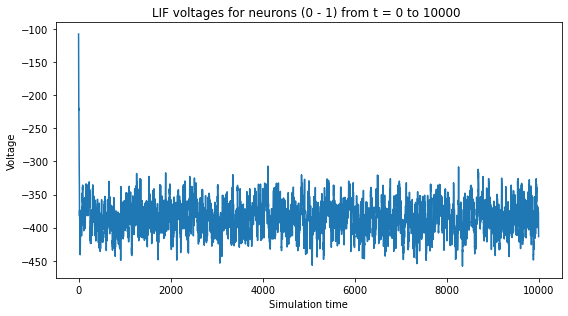

In [4]:
bindsnet.analysis.plotting.plot_voltages({"LIF": voltages[:,:,input_mean_range == -30,input_std_range == 10]}, plot_type="line")
plt.show()

This shows a similar result to the figure in the paper, with much higher firing rates. The refractory period is 1 ms which limits the max firing rate to 500 (with a dt of 1 ms, the input neuron alternates between firing and being in the refractory period each timestep).

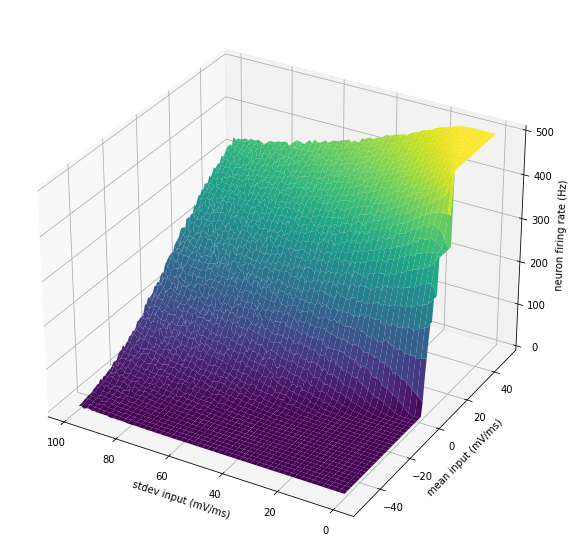

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(stds.T.numpy(), means.T.numpy(), firing_rates.T.numpy(), cmap=matplotlib.cm.viridis)
ax.set_xlabel('stdev input (mV/ms)')
ax.set_ylabel('mean input (mV/ms)')
ax.set_zlabel('neuron firing rate (Hz)')
ax.invert_xaxis()
plt.show()

The sigmoidal firing rate of the neuron becomes smoother as more noise is present.

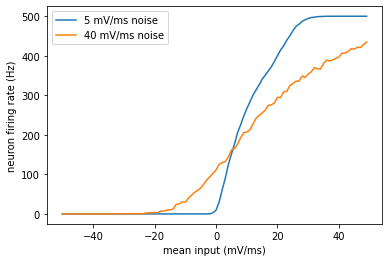

In [6]:
plt.plot(input_mean_range, firing_rates[:,input_std_range == 5].squeeze(), label='5 mV/ms noise')
plt.plot(input_mean_range, firing_rates[:,input_std_range == 40].squeeze(), label='40 mV/ms noise')
plt.legend()
plt.xlabel('mean input (mV/ms)')
plt.ylabel('neuron firing rate (Hz)')
plt.show()

Homeostatic firing rate traces (with a time constant of 1 s). They follow the firing rates of the neurons quite slowly.

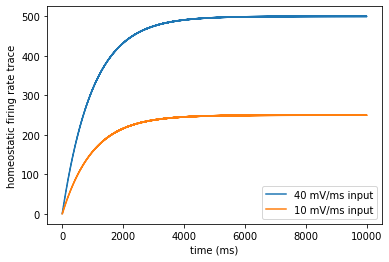

In [7]:
plt.plot(homeostatic_trace[:,:,input_mean_range == 40,input_std_range == 0].squeeze(), label='40 mV/ms input')
plt.plot(homeostatic_trace[:,:,input_mean_range == 10,input_std_range == 0].squeeze(), label='10 mV/ms input')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('homeostatic firing rate trace')
plt.show()